Neural networks are sensitive to the training data, and produce different set of parameters each time we run the program due to the random initializations of the parameters. It causes different predictions each time. This situations leads to high variance in the predictions, which is an unfavourable condition. The variance can be reduced by building multiple models and combine the predictions from each model to obtain the final prediction. 

There are three approaches to build such models,

*   **Training data**: Use different combinations of the trainin data to build the models
*   **Ensembel model**: Use different models 
*   **Combinations**: Use different ways of combining the outputs

There are different ways of implementing models by considering the above conditions. Here, we will discuss the following methods to deal with the high variance problem in the predictions caused by the DL models.

*   Training data: k-fold Cross-Validation Ensemble
*   Ensemble model: Snapshot Ensemble, Horizontal Epochs Ensemble
*   Combinations: Model Averaging Ensemble,Weighted Average Ensemble, 
Stacked Generalization (stacking) Ensemble,
Model Weight Averaging Ensemble









## K-fold cross-validation

>0.834
>0.810
>0.822
Estimated Accuracy 0.822 +/- 0.010
> 1: single=0.817, ensemble=0.817
> 2: single=0.813, ensemble=0.816
> 3: single=0.819, ensemble=0.818
Accuracy 0.816 +/- 0.003


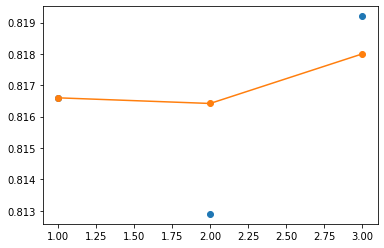

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import tensorflow as tf
from matplotlib import pyplot
import numpy as np
 
# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
  # encode targets
  trainy_enc = tf.keras.utils.to_categorical(trainy)
  testy_enc = tf.keras.utils.to_categorical(testy)
  # define model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(50, input_dim=2, activation='relu'))
  model.add(tf.keras.layers.Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit model
  model.fit(trainX, trainy_enc, epochs=10, verbose=0)
  # evaluate the model
  _, test_acc = model.evaluate(testX, testy_enc, verbose=0)
  return model, test_acc
 
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = np.array(yhats)
  # mean across ensemble members
  avg = np.mean(yhats, axis=0)
  # argmax across classes
  result = np.argmax(avg, axis=1)
  return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 
# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

# prepare the k-fold cross-validation configuration
n_folds = 3
kfold = KFold(n_splits=n_folds, random_state=1, shuffle=True)

# cross validation estimation of performance
scores, members = list(), list()
for train_ix, test_ix in kfold.split(X):
	# select samples
	trainX, trainy = X[train_ix], y[train_ix]
	testX, testy = X[test_ix], y[test_ix]
	# evaluate model
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)
 
# summarize expected performance
print('Estimated Accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()

for i in range(1, n_folds+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = tf.keras.utils.to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
 
# plot score vs number of ensemble members
print('Accuracy %.3f +/- %.3f' % (np.mean(single_scores), np.std(single_scores)))
x_axis = [i for i in range(1, n_folds+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## Snapshot ensemble

>saved snapshot snapshot_model_1.h5, epoch 9
>saved snapshot snapshot_model_2.h5, epoch 19
>saved snapshot snapshot_model_3.h5, epoch 29
>saved snapshot snapshot_model_4.h5, epoch 39
>saved snapshot snapshot_model_5.h5, epoch 49
>saved snapshot snapshot_model_6.h5, epoch 59
>saved snapshot snapshot_model_7.h5, epoch 69
>saved snapshot snapshot_model_8.h5, epoch 79
>saved snapshot snapshot_model_9.h5, epoch 89
>saved snapshot snapshot_model_10.h5, epoch 99
Train: 0.840, Test: 0.790


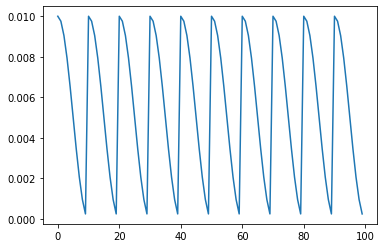

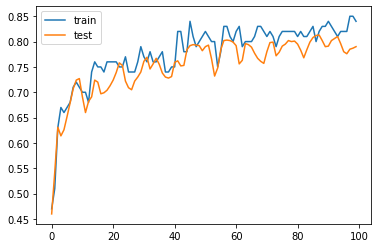

In [ ]:
# mlp with cosine annealing learning rate schedule on blobs problem
from sklearn.datasets import make_blobs
import tensorflow as tf
from math import pi
from math import cos
from math import floor
from matplotlib import pyplot
 
# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(tf.keras.callbacks.Callback):
	# constructor
	def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
		self.epochs = n_epochs
		self.cycles = n_cycles
		self.lr_max = lrate_max
		self.lrates = list()
 
	# calculate learning rate for an epoch
	def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
		epochs_per_cycle = floor(n_epochs/n_cycles)
		cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
		return lrate_max/2 * (cos(cos_inner) + 1)
 
	# calculate and set learning rate at the start of the epoch
	def on_epoch_begin(self, epoch, logs=None):
		# calculate learning rate
		lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
		# set learning rate
		tf.keras.backend.set_value(self.model.optimizer.lr, lr)
		# log value
		self.lrates.append(lr)
  # save models at the end of each cycle
	def on_epoch_end(self, epoch, logs={}):
		# check if we can save model
		epochs_per_cycle = floor(self.epochs / self.cycles)
		if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
			# save model to file
			filename = "snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
			self.model.save(filename)
			print('>saved snapshot %s, epoch %d' % (filename, epoch))

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = tf.keras.utils.to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(25, input_dim=2, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
opt = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# define learning rate callback
n_epochs = 100
n_cycles = n_epochs / 10
ca = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, 0.01)
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=n_epochs, verbose=0, callbacks=[ca])
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot learning rate
pyplot.plot(ca.lrates)
pyplot.show()
# learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

(100, 2) (1000, 2)
>loaded snapshot_model_1.h5
>loaded snapshot_model_2.h5
>loaded snapshot_model_3.h5
>loaded snapshot_model_4.h5
>loaded snapshot_model_5.h5
>loaded snapshot_model_6.h5
>loaded snapshot_model_7.h5
>loaded snapshot_model_8.h5
>loaded snapshot_model_9.h5
>loaded snapshot_model_10.h5
Loaded 10 models
> 1: single=0.790, ensemble=0.790
> 2: single=0.790, ensemble=0.791
> 3: single=0.801, ensemble=0.794
> 4: single=0.757, ensemble=0.790
> 5: single=0.799, ensemble=0.792
> 6: single=0.782, ensemble=0.792
> 7: single=0.731, ensemble=0.787
> 8: single=0.740, ensemble=0.787
> 9: single=0.713, ensemble=0.781
> 10: single=0.727, ensemble=0.783
Accuracy 0.763 +/- 0.032)


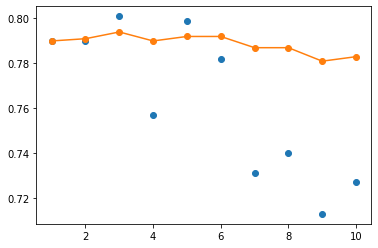

In [ ]:
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'snapshot_model_' + str(i + 1) + '.h5'
		# load model from file
		model = tf.keras.models.load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load models in order
members = load_all_models(10)
print('Loaded %d models' % len(members))
# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(members, i, testX, testy)
	# evaluate the i'th model standalone
	testy_enc = tf.keras.utils.to_categorical(testy)
	_, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
	# summarize this step
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f +/- %.3f)' % (np.mean(single_scores), np.std(single_scores)))
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## Horizontal ensemble

In [ ]:
# save horizontal voting ensemble members during training
from sklearn.datasets import make_blobs
import tensorflow as tf
from matplotlib import pyplot
from os import makedirs
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = tf.keras.utils.to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# define model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(25, input_dim=2, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# create directory for models
makedirs('models')
# fit model
n_epochs, n_save_after = 1000, 950
for i in range(n_epochs):
	# fit model for a single epoch
	model.fit(trainX, trainy, epochs=1, verbose=0)
	# check if we should save the model
	if i >= n_save_after:
		model.save('models/model_' + str(i) + '.h5')

(100, 2) (1000, 2)


(100, 2) (1000, 2)
>loaded models/model_950.h5
>loaded models/model_951.h5
>loaded models/model_952.h5
>loaded models/model_953.h5
>loaded models/model_954.h5
>loaded models/model_955.h5
>loaded models/model_956.h5
>loaded models/model_957.h5
>loaded models/model_958.h5
>loaded models/model_959.h5
>loaded models/model_960.h5
>loaded models/model_961.h5
>loaded models/model_962.h5
>loaded models/model_963.h5
>loaded models/model_964.h5
>loaded models/model_965.h5
>loaded models/model_966.h5
>loaded models/model_967.h5
>loaded models/model_968.h5
>loaded models/model_969.h5
>loaded models/model_970.h5
>loaded models/model_971.h5
>loaded models/model_972.h5
>loaded models/model_973.h5
>loaded models/model_974.h5
>loaded models/model_975.h5
>loaded models/model_976.h5
>loaded models/model_977.h5
>loaded models/model_978.h5
>loaded models/model_979.h5
>loaded models/model_980.h5
>loaded models/model_981.h5
>loaded models/model_982.h5
>loaded models/model_983.h5
>loaded models/model_984.h5
>

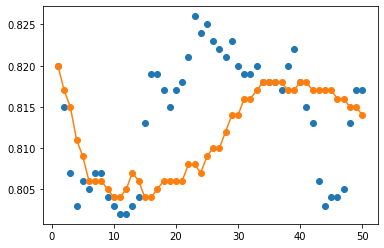

In [ ]:
# load models and make predictions using a horizontal voting ensemble
import numpy as np
from sklearn.metrics import accuracy_score
 
# load models from file
def load_all_models(n_start, n_end):
	all_models = list()
	for epoch in range(n_start, n_end):
		# define filename for this ensemble
		filename = 'models/model_' + str(epoch) + '.h5'
		# load model from file
		model = tf.keras.models.load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load models in order
members = load_all_models(950, 1000)
print('Loaded %d models' % len(members))
# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(members, i, testX, testy)
	# evaluate the i'th model standalone
	testy_enc = tf.keras.utils.to_categorical(testy)
	_, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
	# summarize this step
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f +/- %.3f' % (np.mean(single_scores), np.std(single_scores)))
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## Model Averaging

In [ ]:
# repeated evaluation of model averaging ensemble on blobs dataset
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.metrics import accuracy_score

# fit model on dataset
def fit_model(trainX, trainy):
	# define model
	model = tf.keras.models.Sequential()
	model.add(tf.keras.layers.Dense(15, input_dim=2, activation='relu'))
	model.add(tf.keras.layers.Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=200, verbose=0)
	return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result

# evaluate ensemble model
def evaluate_members(members, testX, testy):
	# make prediction
	yhat = ensemble_predictions(members, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
trainy = tf.keras.utils.to_categorical(trainy)
# repeated evaluation
n_repeats = 30
n_members = 5
scores = list()
for _ in range(n_repeats):
	# fit all models
	members = [fit_model(trainX, trainy) for _ in range(n_members)]
	# evaluate ensemble
	score = evaluate_members(members, testX, testy)
	print('> %.3f' % score)
	scores.append(score)
# summarize the distribution of scores
print('Scores Mean: %.3f +/- Standard Deviation: %.3f' % (np.mean(scores), np.std(scores)))

> 0.769
> 0.763
> 0.774
> 0.771
> 0.769
> 0.780
> 0.766
> 0.769
> 0.760
> 0.769
> 0.766
> 0.766
> 0.766
> 0.763
> 0.786
> 0.771
> 0.766
> 0.757
> 0.774
> 0.774
> 0.766
> 0.771
> 0.774
> 0.769
> 0.780
> 0.769
> 0.763
> 0.760
> 0.769
> 0.771
Scores Mean: 0.769 +/- Standard Deviation: 0.006


## Weighted Average Ensemble

In [ ]:
# global optimization to find coefficients for weighted ensemble on blobs problem
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import tensorflow as tf
from matplotlib import pyplot
import numpy as np
from scipy.optimize import differential_evolution
 
# fit model on dataset
def fit_model(trainX, trainy):
	trainy_enc = tf.keras.utils.to_categorical(trainy)
	# define model
	model = tf.keras.models.Sequential()
	model.add(tf.keras.layers.Dense(25, input_dim=2, activation='relu'))
	model.add(tf.keras.layers.Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy_enc, epochs=500, verbose=0)
	return model
 
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# weighted sum across ensemble members
	summed = np.tensordot(yhats, weights, axes=((0),(0)))
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result
 
# # evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
	# make prediction
	yhat = ensemble_predictions(members, weights, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 
# normalize a vector to have unit norm
def normalize(weights):
	# calculate l1 vector norm
	result = np.linalg.norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result
 
# loss function for optimization process, designed to be minimized
def loss_function(weights, members, testX, testy):
	# normalize weights
	normalized = normalize(weights)
	# calculate error rate
	return 1.0 - evaluate_ensemble(members, normalized, testX, testy)
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# fit all models
n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]
# evaluate each single model on the test set
testy_enc = tf.keras.utils.to_categorical(testy)
for i in range(n_members):
	_, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
	print('Model %d: %.3f' % (i+1, test_acc))
# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)
# define bounds on each weight
bound_w = [(0.0, 1.0)  for _ in range(n_members)]
# arguments to the loss function
search_arg = (members, testX, testy)
# global optimization of ensemble weights
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7)
# get the chosen weights
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)
# evaluate chosen weights
score = evaluate_ensemble(members, weights, testX, testy)
print('Optimized Weights Score: %.3f' % score)

(100, 2) (1000, 2)
Model 1: 0.804
Model 2: 0.801
Model 3: 0.800
Model 4: 0.809
Model 5: 0.818
Equal Weights Score: 0.808
Optimized Weights: [0.17721318 0.15918553 0.02663667 0.3212072  0.31575742]
Optimized Weights Score: 0.817


## Stacking Ensemble

In [ ]:
# example of saving sub-models for later use in a stacking ensemble
from sklearn.datasets import make_blobs
import tensorflow as tf
from matplotlib import pyplot
from os import makedirs
 
# fit model on dataset
def fit_model(trainX, trainy):
	# define model
	model = tf.keras.models.Sequential()
	model.add(tf.keras.layers.Dense(25, input_dim=2, activation='relu'))
	model.add(tf.keras.layers.Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=500, verbose=0)
	return model
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = tf.keras.utils.to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# create directory for models
makedirs('stack_models')
# fit and save models
n_members = 5
for i in range(n_members):
	# fit model
	model = fit_model(trainX, trainy)
	# save model
	filename = 'stack_models/model_' + str(i + 1) + '.h5'
	model.save(filename)
	print('>Saved %s' % filename)

(100, 2) (1000, 2)
>Saved stack_models/model_1.h5
>Saved stack_models/model_2.h5
>Saved stack_models/model_3.h5
>Saved stack_models/model_4.h5
>Saved stack_models/model_5.h5


In [ ]:
# stacked generalization with linear meta model on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from numpy import dstack
 
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'stack_models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = tf.keras.models.load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = np.dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX
 
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model
 
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# evaluate standalone models on test dataset
for model in members:
	testy_enc = tf.keras.utils.to_categorical(testy)
	_, acc = model.evaluate(testX, testy_enc, verbose=0)
	print('Model Accuracy: %.3f' % acc)
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy)
# evaluate model on test set
yhat = stacked_prediction(members, model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

(100, 2) (1000, 2)
>loaded stack_models/model_1.h5
>loaded stack_models/model_2.h5
>loaded stack_models/model_3.h5
>loaded stack_models/model_4.h5
>loaded stack_models/model_5.h5
Loaded 5 models
Model Accuracy: 0.811
Model Accuracy: 0.810
Model Accuracy: 0.808
Model Accuracy: 0.804
Model Accuracy: 0.805
Stacked Test Accuracy: 0.830
